# END-TO-END IMPACT CALCULATION

Before computing the impact of a given exposure and hazard, it is important to correctly match the exposures' coordinates with the hazard centroids. Try to have similar resolutions in exposures and hazard. By the impact calculation the nearest neighbor for each exposure to the hazard's centroids is searched. 

Hint: set first the `Exposures` and use its coordinates information to set a matching `Hazard`.

## POINT EXPOSURES

If the exposures are points, compute your hazard at that points (if possible).

2019-10-29 18:17:09,532 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf
2019-10-29 18:17:14,037 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2019-10-29 18:17:14,037 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2019-10-29 18:17:14,038 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2019-10-29 18:17:14,039 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2019-10-29 18:17:14,040 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2019-10-29 18:17:14,041 - climada.entity.exposures.base - INFO - centr_ not set.
2019-10-29 18:17:14,042 - climada.entity.exposures.base - INFO - deductible not set.
2019-10-29 18:17:14,043 - climada.entity.exposures.base - INFO - cover not set.
2019-10-29 18:17:14,043 - climada.entity.exp

/Users/aznarsig/Documents/Python/climada_python/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2019-10-29 18:17:18,171 - climada.hazard.tc_tracks - INFO - Reading 2007314N10093: SIDR
2019-10-29 18:17:18,308 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2019-10-29 18:17:18,311 - climada.hazard.centroids.centr - DEBUG - Setting dist_coast 7 points.
2019-10-29 18:17:18,913 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 7 centroids.
2019-10-29 18:17:22,497 - climada.hazard.trop_cyclone - DEBUG - Append events.
2019-10-29 18:17:22,499 - climada.hazard.trop_cyclone - DEBUG - Compute frequency.
2019-10-29 18:17:22,713 - climada.entity.exposures.base - INFO - Matching 7 exposures with 7 centroids.
2019-10-29 18:17:22,715 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 1 events.
2019-10-29 18:17:22,716 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_TC. Using impact functions in if_.
Nearest neighbor hazard.centroids indexes for each exposure: [0 1 2 3 4 5 6]


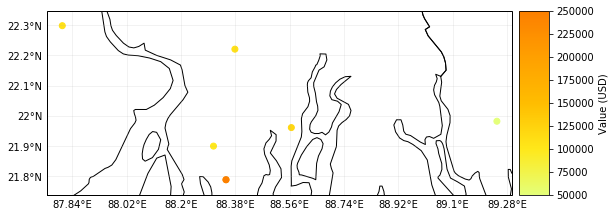

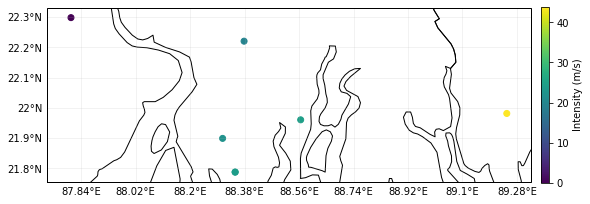

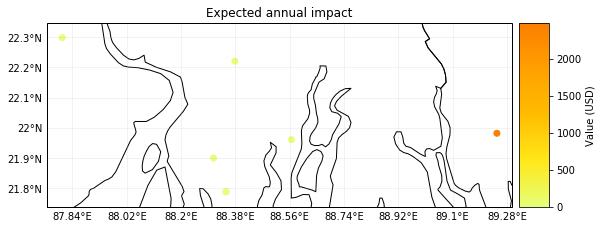

In [1]:
%matplotlib inline
# EXAMPLE: POINT EXPOSURES WITH POINT HAZARD
import numpy as np
from climada.entity import Exposures, ImpactFuncSet, IFTropCyclone
from climada.hazard import Centroids, TCTracks, TropCyclone
from climada.engine import Impact

# Set Exposures in points
exp_pnt = Exposures(crs={'init':'epsg:4326'})
exp_pnt['latitude'] = np.array([21.899326, 21.960728, 22.220574, 22.298390, 21.787977, 21.787977, 21.981732])
exp_pnt['longitude'] = np.array([88.307422, 88.565362, 88.378337, 87.806356, 88.348835, 88.348835, 89.246521])
exp_pnt['value'] = np.array([1.0e5, 1.2e5, 1.1e5, 1.1e5, 2.0e5, 2.5e5, 0.5e5])
exp_pnt.check()
exp_pnt.plot_scatter(buffer=0.05)

# Set Hazard in Exposures points
# set centroids from exposures coordinates
centr_pnt = Centroids()
centr_pnt.set_lat_lon(exp_pnt.latitude.values, exp_pnt.longitude.values, exp_pnt.crs)
# compute Hazard in that centroids
tr_pnt = TCTracks()
tr_pnt.read_ibtracs_netcdf(storm_id='2007314N10093')
tc_pnt = TropCyclone()
tc_pnt.set_from_tracks(tr_pnt, centroids=centr_pnt)
tc_pnt.check()
ax_pnt = tc_pnt.centroids.plot(c=np.array(tc_pnt.intensity[0,:].todense()).squeeze()) # plot intensity per point
ax_pnt.get_figure().colorbar(ax_pnt.collections[0], fraction=0.0175, pad=0.02).set_label('Intensity (m/s)') # add colorbar
#ax_pnt.get_figure().set_label('Intensity (m/s)')

# Set impact function
if_pnt = ImpactFuncSet()
if_tc = IFTropCyclone()
if_tc.set_emanuel_usa()
if_pnt.append(if_tc)
if_pnt.check()

# Compute Impact
imp_pnt = Impact()
imp_pnt.calc(exp_pnt, if_pnt, tc_pnt)
# nearest neighbor of exposures to centroids gives identity
print('Nearest neighbor hazard.centroids indexes for each exposure:', exp_pnt.centr_TC.values)
imp_pnt.plot_scatter_eai_exposure(ignore_zero=False, buffer=0.05)

## EXPOSURES FROM A RASTER

If the exposures represent values per pixel (belong to a raster), transform your hazard to a raster in the same reference system using the raster resampling options.

`BlackMarble` and `LitPop` belong to this category.

2019-10-29 18:17:26,274 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 300.0 arcsec.
2019-10-29 18:17:26,275 - climada.entity.exposures.nightlight - DEBUG - Found all required satellite data (1 files) in folder /Users/aznarsig/Documents/Python/climada_python/data/system
2019-10-29 18:17:26,276 - climada.entity.exposures.litpop - DEBUG - Importing /Users/aznarsig/Documents/Python/climada_python/data/system/BlackMarble_2016_B1_geo_gray.tif.
2019-10-29 18:17:29,666 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2019-10-29 18:17:29,667 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2019-10-29 18:17:29,667 - climada.entity.exposures.gpw_import - DEBUG - Importing /Users/aznarsig/Documents/Python/climada_python/data/system/gpw_v4_population_count_rev11_2015_30_sec.tif
2019-10-29 18:17:41,969 - climada.util.finance - INFO - GDP VEN 2014: 4.824e+11.
2019-10-2

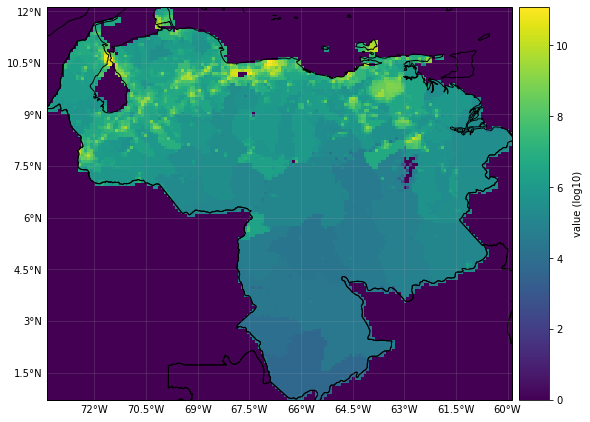

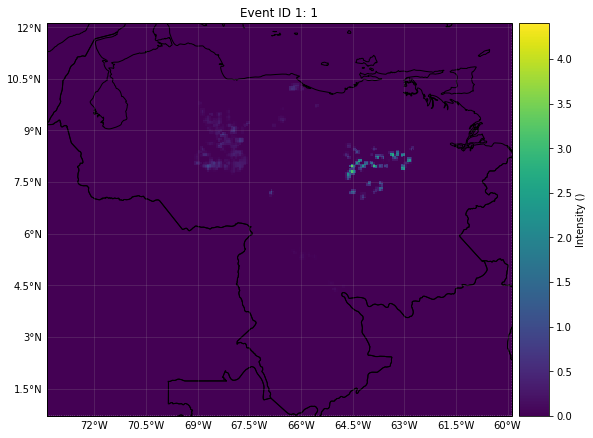

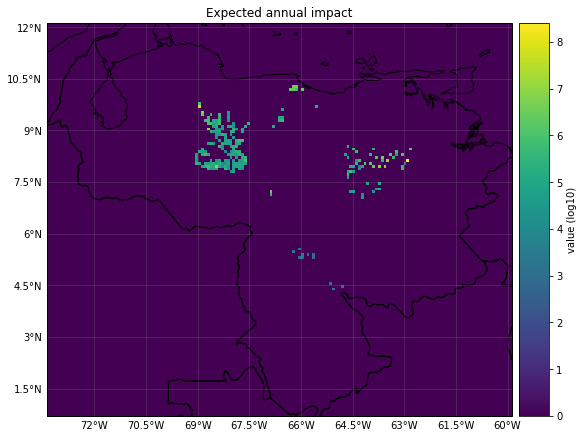

In [2]:
# EXAMPLE: RASTER EXPOSURES WITH RASTER HAZARD
from rasterio.warp import Resampling
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.util.constants import HAZ_DEMO_FL

# Exposures belonging to a raster contain the meta attribute
exp_ras = LitPop()
exp_ras.set_country(countries=['VEN'], res_km=10, fin_mode='income_group')
exp_ras.reset_index()
exp_ras.check()
exp_ras.plot_raster()
print('\n Raster properties exposures:', exp_ras.meta)

# Resample hazard raster to the exposures' ones
haz_ras = Hazard('FL')
# check how other resampling methods affect to final impact
haz_ras.set_raster([HAZ_DEMO_FL], dst_crs=exp_ras.meta['crs'], transform=exp_ras.meta['transform'], 
                   width=exp_ras.meta['width'], height=exp_ras.meta['height'], 
                   resampling=Resampling.nearest)
haz_ras.intensity[haz_ras.intensity==-9999] = 0 # correct no data values
haz_ras.check()
haz_ras.plot_intensity(1)
print('Raster properties centroids:', haz_ras.centroids.meta)

# Set dummy impact function
if_ras = ImpactFuncSet()
if_dum = ImpactFunc()
if_dum.id = 1
if_dum.name = 'dummy'
if_dum.intensity_unit = 'm'
if_dum.haz_type = 'FL'
if_dum.intensity = np.linspace(0, 10, 100)
if_dum.mdd = np.linspace(0, 10, 100)
if_dum.paa = np.ones(if_dum.intensity.size)
if_ras.append(if_dum)
if_ras.check()

# Compute impact
imp_ras = Impact()
imp_ras.calc(exp_ras, if_ras, haz_ras, save_mat=False)
# nearest neighbor of exposures to centroids is not identity because litpop does not contain data outside the country polygon
print('\n Nearest neighbor hazard.centroids indexes for each exposure:', exp_ras.centr_FL.values)
imp_ras.plot_raster_eai_exposure()

# VISUALIZATION

The expected annual impact per exposure can be visualized through different methods: `plot_hexbin_eai_exposure()`, `plot_scatter_eai_exposur()`, `plot_raster_eai_exposure()` and `plot_basemap_eai_exposure()` (similarly as with  `Exposures`).

2019-10-29 18:17:51,203 - climada.util.coordinates - INFO - Setting geometry points.
2019-10-29 18:17:51,212 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2019-10-29 18:17:52,247 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


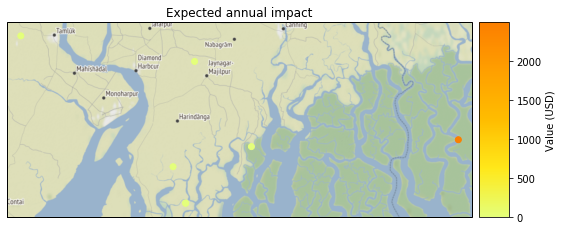

In [3]:
imp_pnt.plot_basemap_eai_exposure(buffer=5000)

## Making videos

Given a fixed exposure and impact functions, a sequnce of hazards can be visualized hitting the exposures.

2019-10-29 18:17:55,127 - climada.util.finance - INFO - GDP USA 2016: 1.871e+13.
2019-10-29 18:17:55,180 - climada.util.finance - INFO - Income group USA 2016: 4.
2019-10-29 18:17:55,180 - climada.entity.exposures.black_marble - INFO - Nightlights from NASA's earth observatory for year 2016.
2019-10-29 18:17:55,796 - climada.entity.exposures.nightlight - DEBUG - Found all required satellite data (4 files) in folder /Users/aznarsig/Documents/Python/climada_python/data/system
2019-10-29 18:17:55,797 - climada.entity.exposures.nightlight - DEBUG - All required files already exist. No downloads necessary.
2019-10-29 18:21:45,895 - climada.entity.exposures.black_marble - INFO - Processing country United States Of America.
2019-10-29 18:29:41,450 - climada.entity.exposures.black_marble - INFO - Generating resolution of approx 2.5 km.
2019-10-29 18:29:42,812 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2019-10-29 18:29:42,815 - climada.entity.exposures.base - INFO - cen

23it [07:27, 28.51s/it]                        


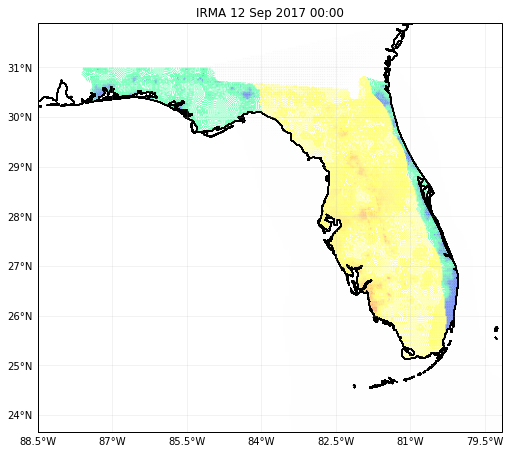

In [4]:
# exposure
from climada.entity import BlackMarble, add_sea
country_name = {'United States Of America': ['Florida']}
exp_video = BlackMarble()
exp_video.set_countries(country_name, 2016, res_km=2.5)
exp_video.check()

# impact function
if_def = IFTropCyclone()
if_def.set_emanuel_usa()
ifs_video = ImpactFuncSet()
ifs_video.append(if_def)
ifs_video.check()

# compute sequence of hazards using TropCyclone video_intensity method
exp_sea = add_sea(exp_video, (100, 5))
centr_video = Centroids()
centr_video.set_lat_lon(exp_sea.latitude.values, exp_sea.longitude.values)
centr_video.check()

track_name = '2017242N16333' 
tr_irma = TCTracks()
tr_irma.read_ibtracs_netcdf(provider='usa', storm_id=track_name) # IRMA 2017

tc_video = TropCyclone()
tc_list, _ = tc_video.video_intensity(track_name, tr_irma, centr_video) # empty file name to not to write the video

# generate video of impacts
file_name='./results/irma_imp_fl.gif'
imp_video = Impact()
imp_list = imp_video.video_direct_impact(exp_video, ifs_video, tc_list, file_name)
